In [98]:
%pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [99]:
%pip install opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.


In [100]:
%pip install tensorflow 

Note: you may need to restart the kernel to use updated packages.


In [101]:
##Import Dependincies
import cv2 
import os 
import random 
import numpy as np
import matplotlib.pyplot as plt

In [102]:
#Import tensorflow dependencies - functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Layer, Input
import tensorflow as tf

In [103]:
#Set Gpu Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [104]:
#Setup Folder Structure
# Setup paths
pos_path = os.path.join('data','positive')
neg_path = os.path.join('data','negative')
anc_path = os.path.join('data','anchor')

In [105]:
#Make directories
os.makedirs(pos_path)
os.makedirs(neg_path)
os.makedirs(anc_path)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [106]:
#move the dataset into the data-neg_path folder
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        ex_path = os.path.join('lfw', directory,file)
        new_path = os.path.join(neg_path,file)
        os.replace(ex_path,new_path)

print("hello world")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'lfw'

In [107]:
#Import uuid library to generate unique image names
import uuid

In [108]:
#collect positive and anchor classes
cap =cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame=cap.read()

    frame = frame[120:120+250,200:200+250,:]
    #collect anchor image 
    if cv2.waitKey(1)& 0XFF == ord('p'):
        # creat the image path
        imgname=os.path.join(anc_path,'{}.jpg'.format(uuid.uuid1()))
        #write out the anchor image
        cv2.imwrite(imgname,frame)

    #collect postive image
    if cv2.waitKey(1)& 0XFF == ord('i'):
        imgname=os.path.join(pos_path, '{}.jgp'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)

    #SHOW IMAGE BACK TO SCREEN
    cv2.imshow('Image Collection',frame)

    #breaking gracefully
    if cv2.waitKey(1)& 0XFF == ord('q'):
        break
# relase the webcam and destroy all open cv windows
cap.release()
cv2.destroyAllWindows()

In [109]:
# Get Image Directories
anchor = tf.data.Dataset.list_files(anc_path+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(pos_path+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(neg_path+'/*.jpg').take(300)

In [121]:
#PreProcessing the data and scale and re size 
def preprocess(file_path):
    #read the file
    byte_img = tf.io.read_file(file_path)
    #load in the image
    img = tf.io.decode_jpeg(byte_img)
    #resize the image
    img = tf.image.resize(img,(100,100))
    #scale the image between 0 and 1 
    img = img/255.0
    return img

In [122]:
#Create Labelled Dataset
positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [112]:
samples = data.as_numpy_iterator()
print(samples.next())

(b'data\\anchor\\3d32ec97-9235-11f0-9f54-a02942cd9456.jpg', b'data\\positive\\975cf3ca-9252-11f0-bdb1-a02942cd9456.jpg', np.float32(1.0))


In [123]:
#Build Train and Test Partition
def preprocess_twin(input_img , validation_img,label):
    return(preprocess(input_img),preprocess(validation_img),label)

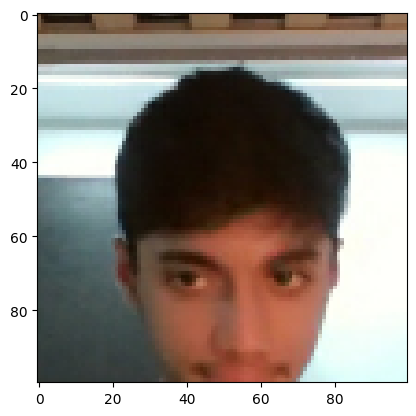

In [133]:
res = preprocess_twin(*samples.next())
plt.imshow(res[0])


np.float32(1.0)

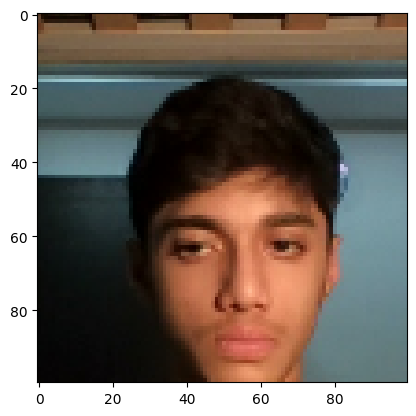

In [134]:
plt.imshow(res[1])
res[2]

In [126]:
#Build Dataloader Pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [127]:
# Training Partition 
train_data=data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8) 


In [ ]:
  #Testing Partition 
test_data = data.skip(round(len(data)*.7))
test_data = data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [178]:
# Make Embedding Layer

def make_embedding():
    inp = Input(shape=(100,100,3),name = 'input_image')
    #First Block
    c1= Conv2D(64,(10,10),activation='relu')(inp)
    m1 = MaxPooling2D(64,(2,2),padding='same')(c1)
    #Second Block
    c2= Conv2D(128,(7,7),activation='relu')(m1)
    m2 = MaxPooling2D(64,(2,2),padding='same')(c2)
    #Third Block
    c3= Conv2D(128,(4,4),activation='relu')(m2)
    m3 = MaxPooling2D(64,(2,2),padding='same')(c3)
    #Final Block
    c4= Conv2D(256,(4,4),activation='relu')(m3)
    f1 = Flatten()(c4)
    d1=Dense(4096, activation='sigmoid')(f1)

    return Model(inputs =[inp] , outputs =[d1] , name ='emebedding' )







In [176]:
embedding = make_embedding()
embedding.summary()


Model: "emebedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [187]:
#Make Distance Layer
class L1Dist(Layer):
    def __init__(self,**kwargs):
        super().__init__()

    def call(self,input_embedding,validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [180]:
def make_siamese_model():
    #Handle Inputs
    input_image = Input(name='input_img',shape=(100,100,3))
    validation_image = Input(name='validation_image', shape=(100,100,3))
    #Combining the siamese distnace components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image),embedding(validation_image))
    #Classification Layer
    classifier = Dense(1,activation='sigmoid')(distances)

    return Model(inputs = [input_image,validation_image], outputs = classifier, name='SiameseNetwork')

In [183]:
siamese_model = make_siamese_model()

TypeError: Exception encountered when calling L1Dist.call().

[1mCould not automatically infer the output shape / dtype of 'l1_dist_14' (of type L1Dist). Either the `L1Dist.call()` method is incorrect, or you need to implement the `L1Dist.compute_output_spec() / compute_output_shape()` method. Error encountered:

unsupported operand type(s) for -: 'list' and 'list'[0m

Arguments received by L1Dist.call():
  • args=(['<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, ragged=False, name=keras_tensor_96>'], ['<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, ragged=False, name=keras_tensor_97>'])
  • kwargs=<class 'inspect._empty'>